In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34305")
client

<Client: 'tcp://127.0.0.1:34305' processes=8 threads=40, memory=157.36 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
chaos = '/tank/chaocean/tuchida/'
# savedir = '/tank/chaocean/tuchida/ECycle/'
savedir = '/tank/spectre/tuchida/chaocean/Snap/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

xchunk = 100
ychunk = 100

nmembs = np.arange(100,148)

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,dd:]

array([1419120, 1421280, 1423440, 1425600, 1427760, 1429920, 1432080,
       1434240, 1436400, 1438560, 1440720, 1442880, 1445040, 1447200,
       1449360, 1451520, 1453680, 1455840, 1458000, 1460160, 1462320,
       1464480, 1466640, 1468800, 1470960, 1473120, 1475280, 1477440,
       1479600, 1481760, 1483920, 1486080, 1488240, 1490400, 1492560,
       1494720, 1496880, 1499040, 1501200, 1503360, 1505520, 1507680,
       1509840, 1512000, 1514160, 1516320, 1518480, 1520640, 1522800,
       1524960, 1527120, 1529280, 1531440, 1533600, 1535760, 1537920,
       1540080, 1542240, 1544400, 1546560, 1548720, 1550880, 1553040,
       1555200, 1557360, 1559520, 1561680, 1563840, 1566000, 1568160,
       1570320, 1572480, 1574640])

In [6]:
dsg = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                              % (100)), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=ntimes[0,0], 
                     ).chunk({'YC':ychunk,'YG':ychunk,
                              'XC':xchunk,'XG':xchunk})
grid = Grid(dsg, periodic=['X'])
Vol = (dsg.rA * dsg.drF * dsg.hFacC).where(dsg.maskC!=0.)
dsg

<xarray.Dataset>
Dimensions:  (time: 1, XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47,
              Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3285 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [6]:
for itime in ntimes[yystart,dd+1:]:
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=itime, 
                                ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                      'XC':xchunk,'XG':xchunk})
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=itime, 
                                               ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                                     'XC':xchunk,'XG':xchunk})
                           ], dim='nmemb')

    ds.coords['nmemb'] = ('nmemb',nmembs)
    grid = Grid(ds, periodic=['X'])
    
    dsm = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=itime, 
                         ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                               'XC':xchunk,'XG':xchunk})
    
    wp = ds.WVEL - dsm.WVEL
    vp = ds.VVEL - dsm.VVEL
    up = ds.UVEL - dsm.UVEL
    
    uu = (up**2).mean('nmemb')
    vu = (grid.interp(grid.interp(vp,'X'),'Y',boundary='extend')
          * up).mean('nmemb')
    wu = (grid.interp(grid.interp(wp,'X'),'Z',boundary='extend')
          * up).mean('nmemb')
    
    uv = (grid.interp(grid.interp(up,'X'),'Y',boundary='extend')
          * vp).mean('nmemb')
    vv = (vp**2).mean('nmemb')
    wv = (grid.interp(grid.interp(wp,'Y',boundary='extend'),'Z',boundary='extend')
          * vp).mean('nmemb')
    
    
    
    xAW = (ds.dyG * ds.drF * ds.hFacW).reset_coords(drop=True)
    xAS = (ds.dyC * ds.drF * ds.hFacS).reset_coords(drop=True)
    yAW = (ds.dxC * ds.drF * ds.hFacW).reset_coords(drop=True)
    yAS = (ds.dxG * ds.drF * ds.hFacS).reset_coords(drop=True)
    hFacF = grid.interp(dsg.hFacS,"X")
    
    ux = (grid.diff(dsm.UVEL*xAW,'X') 
          / dsg.drF/dsg.rA/dsg.hFacC)
    uy = (grid.diff(dsm.UVEL*yAW,'Y',boundary='extend') 
          / dsg.drF/dsg.rAz/hFacF)
    uz = (-grid.diff(dsm.UVEL,'Z',boundary='extend') 
          / xr.DataArray(dsg.drC[:-1].data,dims='Zl'))
    
    vx = (grid.diff(dsm.VVEL*xAS,'X') 
          / dsg.drF/dsg.rAz/hFacF)
    vy = (grid.diff(dsm.VVEL*yAS,'Y',boundary='extend') 
          / dsg.drF/dsg.rA/dsg.hFacC)
    vz = (-grid.diff(dsm.VVEL,'Z',boundary='extend') 
          / xr.DataArray(dsg.drC[:-1].data,dims='Zl'))
    
    Pr = ((grid.interp(uu,'X')*ux
           + grid.interp(vu*grid.interp(uy,'Y',boundary='extend'),'X')
           + grid.interp(wu*grid.interp(uz,'Z',boundary='extend'),'X')
          )
          + (grid.interp(uv*grid.interp(vx,'X'),'Y',boundary='extend')
             + grid.interp(vv,'Y',boundary='extend')*vy
             + grid.interp(wv*grid.interp(vz,'Z',boundary='extend'),'Y',boundary='extend')
            )
         )
    
    if itime == ntimes[yystart,dd]:
        Pr.isel(Z=1).plot(vmax=1e-7)
        plt.show()
            
    dsave = Pr.reset_coords(drop=True).chunk({'Z':4,'YC':ychunk,'XC':xchunk}
                                            ).to_dataset(name='ShProd')
    dsave.to_zarr(op.join(savedir,'%4d/%010d/S-P.zarr' 
                          % (years[yystart],itime)), 
                  mode='w')
    dsave.close()
    ds.close()
    dsm.close()
    del Pr
    
    print(itime)

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0


1421280


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1423440


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1425600


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1427760


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1429920


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1432080


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1434240


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1436400


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1438560


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1440720


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1442880


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1445040


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1447200


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1449360


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1451520


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1453680


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1455840


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1458000


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1460160


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1462320


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1464480


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1466640


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1468800


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1470960


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1473120


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1475280


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1477440


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1479600


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1481760


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1483920


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1486080


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1488240


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1490400


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1492560


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1494720


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1496880


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1499040


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1501200


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1503360


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1505520


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1507680


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1509840


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1512000


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1514160


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1516320


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1518480


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1520640


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1522800


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1524960


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1527120


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1529280


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1531440


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1533600


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1535760


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1537920


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1540080


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1542240


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1544400


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1546560


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1548720


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1550880


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1553040


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1555200


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1557360


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1559520


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1561680


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1563840


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1566000


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1568160


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1570320


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1572480


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


1574640


In [7]:
for itime in ntimes[yystart]:
    if itime == ntimes[yystart,0]:
        SP = xr.open_zarr(op.join(savedir,'%4d/%010d/S-P.zarr' 
                                  % (years[yystart],itime))
                         ).ShProd
    else:
        SP = xr.concat([SP, xr.open_zarr(op.join(savedir,'%4d/%010d/S-P.zarr' 
                                  % (years[yystart],itime))
                                        ).ShProd
                       ], 'time')
    print(itime) 

1419120
1421280
1423440
1425600
1427760
1429920
1432080
1434240
1436400
1438560
1440720
1442880
1445040
1447200
1449360
1451520
1453680
1455840
1458000
1460160
1462320
1464480
1466640
1468800
1470960
1473120
1475280
1477440
1479600
1481760
1483920
1486080
1488240
1490400
1492560
1494720
1496880
1499040
1501200
1503360
1505520
1507680
1509840
1512000
1514160
1516320
1518480
1520640
1522800
1524960
1527120
1529280
1531440
1533600
1535760
1537920
1540080
1542240
1544400
1546560
1548720
1550880
1553040
1555200
1557360
1559520
1561680
1563840
1566000
1568160
1570320
1572480
1574640


In [8]:
ymax = 43
ymin = 14
xmin = 270
xmax = 337
  
# ((SP*Vol).sel(
#            Z=slice(None,-1e3),YC=slice(ymin,ymax),
#            XC=slice(xmin,xmax)
#           ).sum(['Z','YC','XC'],skipna=True)
#  / Vol.sel(
#            Z=slice(None,-1e3),YC=slice(ymin,ymax),
#            XC=slice(xmin,xmax)
#           ).sum(['Z','YC','XC'],skipna=True)
# ).reset_coords(drop=True).chunk({'time':-1}
#                                ).to_dataset(name='ShProd').to_zarr(op.join(savedir,
#                                       '%4d/S-P_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
#                                       % (years[yystart],ymin,ymax,xmin,xmax)
#                                       # '%4d/S-P_VolAve.zarr' 
#                                       # % (years[yystart])
#                                                                       ), mode='w')
((SP.mean('time')*Vol).sel(
           Z=slice(None,-1e3),YC=slice(ymin,ymax),
           XC=slice(xmin,xmax)
          ).sum(['Z','YC','XC'],skipna=True)
 / Vol.sel(
           Z=slice(None,-1e3),YC=slice(ymin,ymax),
           XC=slice(xmin,xmax)
          ).sum(['Z','YC','XC'],skipna=True)
).reset_coords(drop=True).compute()

<xarray.DataArray ()>
array(-1.8789839e-09, dtype=float32)

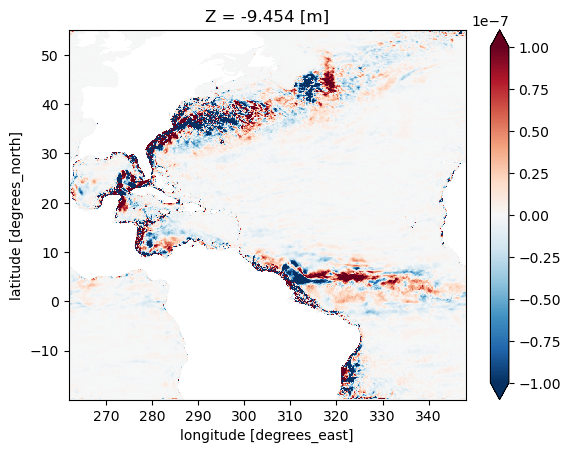

1419120


In [10]:
for itime in ntimes[yystart,:1]:
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=itime, 
                                ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                      'XC':xchunk,'XG':xchunk})
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn'], delta_t=2e2,
                                                iters=itime, 
                                               ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                                     'XC':xchunk,'XG':xchunk})
                           ], dim='nmemb')

    ds.coords['nmemb'] = ('nmemb',nmembs)
    grid = Grid(ds, periodic=['X'])
    
    dsm = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=itime, 
                         ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                               'XC':xchunk,'XG':xchunk})
    
    wp = ds.WVEL - dsm.WVEL
    vp = ds.VVEL - dsm.VVEL
    up = ds.UVEL - dsm.UVEL
    
    uu = (up**2).mean('nmemb')
    vu = (grid.interp(grid.interp(vp,'X'),'Y',boundary='extend')
          * up).mean('nmemb')
    wu = (grid.interp(grid.interp(wp,'X'),'Z',boundary='extend')
          * up).mean('nmemb')
    
    uv = (grid.interp(grid.interp(up,'X'),'Y',boundary='extend')
          * vp).mean('nmemb')
    vv = (vp**2).mean('nmemb')
    wv = (grid.interp(grid.interp(wp,'Y',boundary='extend'),'Z',boundary='extend')
          * vp).mean('nmemb')
    
    
    
    xAW = (ds.dyG * ds.drF * ds.hFacW).reset_coords(drop=True)
    xAS = (ds.dyC * ds.drF * ds.hFacS).reset_coords(drop=True)
    yAW = (ds.dxC * ds.drF * ds.hFacW).reset_coords(drop=True)
    yAS = (ds.dxG * ds.drF * ds.hFacS).reset_coords(drop=True)
    hFacF = grid.interp(dsg.hFacS,"X")
    
    ux = (grid.diff(dsm.UVEL*xAW,'X') 
          / dsg.drF/dsg.rA/dsg.hFacC)
    uy = (grid.diff(dsm.UVEL*yAW,'Y',boundary='extend') 
          / dsg.drF/dsg.rAz/hFacF)
    uz = (-grid.diff(dsm.UVEL,'Z',boundary='extend') 
          / xr.DataArray(dsg.drC[:-1].data,dims='Zl'))
    
    vx = (grid.diff(dsm.VVEL*xAS,'X') 
          / dsg.drF/dsg.rAz/hFacF)
    vy = (grid.diff(dsm.VVEL*yAS,'Y',boundary='extend') 
          / dsg.drF/dsg.rA/dsg.hFacC)
    vz = (-grid.diff(dsm.VVEL,'Z',boundary='extend') 
          / xr.DataArray(dsg.drC[:-1].data,dims='Zl'))
    
    Prpar = ((grid.interp(uu,'X')*ux
           # + grid.interp(vu*grid.interp(uy,'Y',boundary='extend'),'X')
           # + grid.interp(wu*grid.interp(uz,'Z',boundary='extend'),'X')
          )
          + (
              # grid.interp(uv*grid.interp(vx,'X'),'Y',boundary='extend')
             + grid.interp(vv,'Y',boundary='extend')*vy
             # + grid.interp(wv*grid.interp(vz,'Z',boundary='extend'),'Y',boundary='extend')
            )
         ).reset_coords(drop=True)
    Prorth = ((
        # grid.interp(uu,'X')*ux
           + grid.interp(vu*grid.interp(uy,'Y',boundary='extend'),'X')
           # + grid.interp(wu*grid.interp(uz,'Z',boundary='extend'),'X')
          )
          + (grid.interp(uv*grid.interp(vx,'X'),'Y',boundary='extend')
             # + grid.interp(vv,'Y',boundary='extend')*vy
             # + grid.interp(wv*grid.interp(vz,'Z',boundary='extend'),'Y',boundary='extend')
            )
         ).reset_coords(drop=True)
    
    if itime == ntimes[yystart,dd]:
        Prpar.isel(Z=1).plot(vmax=1e-7)
        plt.show()
            
    dsave = Prpar.chunk({'Z':4,'YC':ychunk,'XC':xchunk}
                                            ).to_dataset(name='para')
    dsave['orth'] = Prorth
    dsave.to_zarr(op.join(savedir,'%4d/%010d/S-P_Horizontal.zarr' 
                          % (years[yystart],itime)), 
                  mode='w')
    dsave.close()
    ds.close()
    dsm.close()
    del Prpar, Prorth
    
    print(itime)

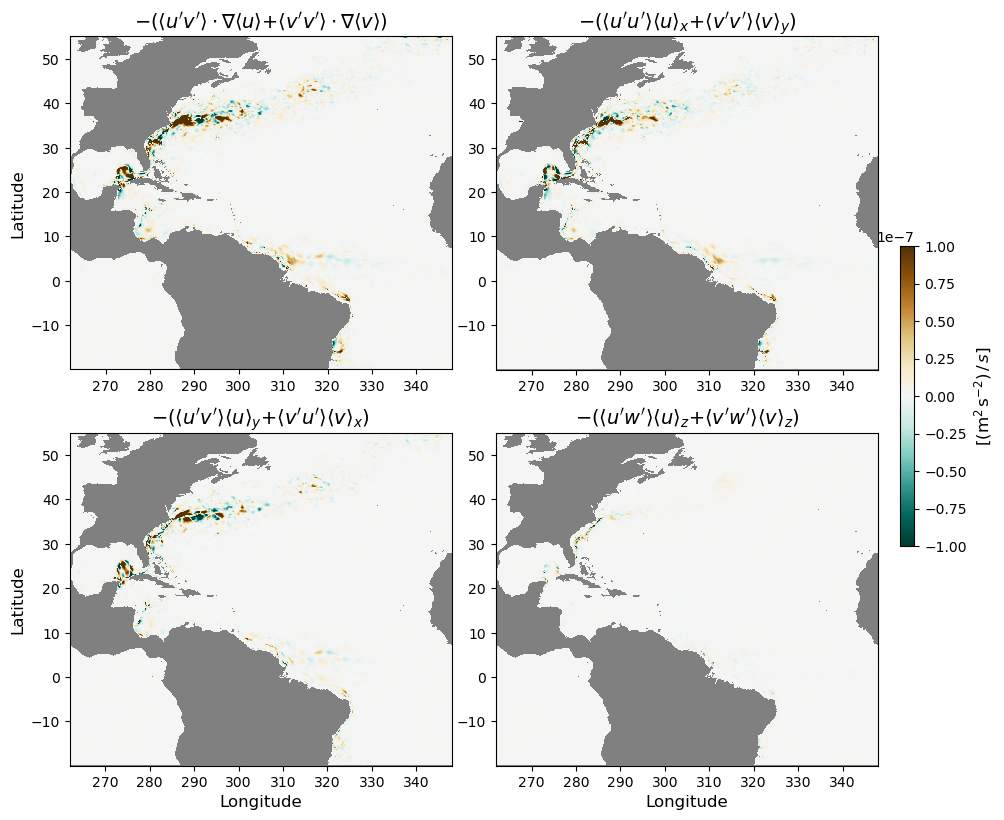

In [14]:
dsh = xr.open_zarr(op.join(savedir,'%4d/%010d/S-P.zarr' 
                          % (years[yystart],ntimes[0,0])))
dshh = xr.open_zarr(op.join(savedir,'%4d/%010d/S-P_Horizontal.zarr' 
                          % (years[yystart],ntimes[0,0])))



fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,10))

im = axes[0,0].pcolormesh(dsg.XC, dsg.YC, 
                   -(dsh.ShProd
                    * dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
                   cmap='BrBG_r', vmax=1e-7, vmin=-1e-7,
                   rasterized=True)
axes[0,1].pcolormesh(dsg.XC, dsg.YC, 
                     -(dshh.para * dsg.drF
                     ).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
                     cmap='BrBG_r', vmax=1e-7, vmin=-1e-7,
                     rasterized=True)
axes[1,0].pcolormesh(dsg.XC, dsg.YC, 
                     -(dshh.orth * dsg.drF).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
                     cmap='BrBG_r', vmax=1e-7, vmin=-1e-7,
                     rasterized=True)
axes[1,1].pcolormesh(dsg.XC, dsg.YC, 
                     -((dsh.ShProd - (dshh.para+dshh.orth)) * dsg.drF
                     ).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
                     cmap='BrBG_r', vmax=1e-7, vmin=-1e-7,
                     rasterized=True)

axes[0,0].set_title(r"$-(\langle u'v'\rangle\cdot\nabla\langle u\rangle$" + 
                    r"$+ \langle v'v'\rangle\cdot\nabla\langle v\rangle)$", 
                    fontsize=14)
axes[0,1].set_title(r"$-(\langle u'u'\rangle\langle u\rangle_x$" + 
                    r"$+ \langle v'v'\rangle\langle v\rangle_y)$",  
                    fontsize=14)
axes[1,0].set_title(r"$-(\langle u'v'\rangle\langle u\rangle_y$" + 
                    r"$+ \langle v'u'\rangle\langle v\rangle_x)$", 
                    fontsize=14)
axes[1,1].set_title(r"$-(\langle u'w'\rangle\langle u\rangle_z$" + 
                    r"$+ \langle v'w'\rangle\langle v\rangle_z)$",
                    fontsize=14)

axes[0,0].pcolormesh(dsg.XG, dsg.YC, dsg.maskInW.where(dsg.maskInW!=1.),
                   vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[0,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskInC.where(dsg.maskInC!=1.),
                   vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskInC.where(dsg.maskInC!=1.),
                   vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskInC.where(dsg.maskInC!=1.),
                   vmin=-2, vmax=2., cmap='binary_r', rasterized=True)

fig.subplots_adjust(right=.86, wspace=.115, hspace=.06) 
cbax = fig.add_axes([0.88, 0.35, 0.013, 0.3])
cbar = fig.colorbar(im, orientation='vertical', cax=cbax)
cbar.set_label(r"[(m$^{2}\,$s$^{-2})\, /\, s$]", fontsize=12)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')

axes[0,0].set_ylabel('Latitude', fontsize=12)
axes[1,0].set_ylabel('Latitude', fontsize=12)
axes[1,0].set_xlabel('Longitude', fontsize=12)
axes[1,1].set_xlabel('Longitude', fontsize=12)

plt.savefig(op.join(savedir,'Figures/ShProd_aveZ1000budget_%010d.pdf' % ntimes[0,0]))

In [8]:
SPw = SP.isel(time=slice(None,19)).mean('time',skipna=True)
SPs = SP.isel(time=slice(36,55)).mean('time',skipna=True)

SPw

<xarray.DataArray 'ShProd' (Z: 46, YC: 900, XC: 1000)>
dask.array<mean_agg-aggregate, shape=(46, 900, 1000), dtype=float32, chunksize=(4, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03

In [9]:
HSPw = ((SPw*dsg.drF).where(SPw.Z>=-1e3).sum('Z',skipna=True)
         * 1e-3).reset_coords(drop=True).compute()
HSPs = ((SPs*dsg.drF).where(SPs.Z>=-1e3).sum('Z',skipna=True)
         * 1e-3).reset_coords(drop=True).compute()

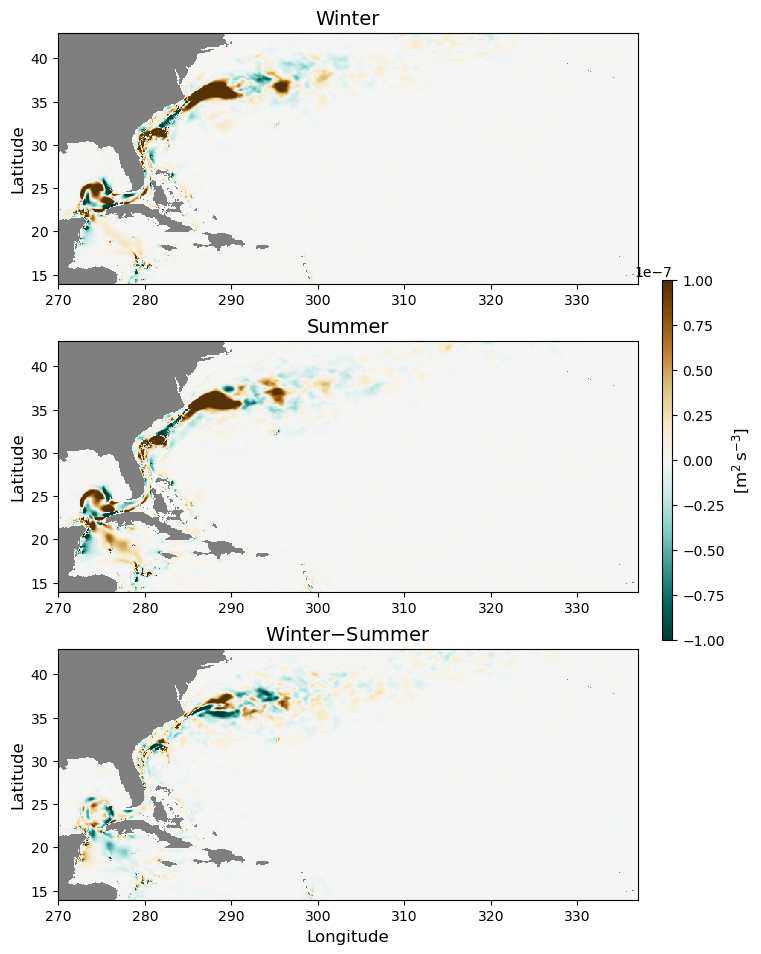

In [26]:
ymax = 43
ymin = 14
xmin = 270
xmax = 337

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(8,12), nrows=3, ncols=1)
# fig.set_tight_layout(True)

im = ax1.pcolormesh(dsg.XC.sel(XC=slice(xmin,xmax)), dsg.YC.sel(YC=slice(ymin,ymax)), 
                    -HSPw.sel(YC=slice(ymin,ymax),XC=slice(xmin,xmax)),
                   cmap='BrBG_r', vmax=1e-7, vmin=-1e-7, rasterized=True)
ax1.pcolormesh(dsg.XC.sel(XC=slice(xmin,xmax)), dsg.YC.sel(YC=slice(ymin,ymax)), 
            dsg.maskC.where(dsg.maskC!=1.).isel(Z=0).sel(YC=slice(ymin,ymax),XC=slice(xmin,xmax)),
               vmin=-2, vmax=2., cmap='binary', rasterized=True)
ax2.pcolormesh(dsg.XC.sel(XC=slice(xmin,xmax)), dsg.YC.sel(YC=slice(ymin,ymax)), 
               -HSPs.sel(YC=slice(ymin,ymax),XC=slice(xmin,xmax)),
               cmap='BrBG_r', vmax=1e-7, vmin=-1e-7, rasterized=True)
ax2.pcolormesh(dsg.XC.sel(XC=slice(xmin,xmax)), dsg.YC.sel(YC=slice(ymin,ymax)),
            dsg.maskC.where(dsg.maskC!=1.).isel(Z=0).sel(YC=slice(ymin,ymax),XC=slice(xmin,xmax)),
               vmin=-2, vmax=2., cmap='binary', rasterized=True)
ax3.pcolormesh(dsg.XC.sel(XC=slice(xmin,xmax)), dsg.YC.sel(YC=slice(ymin,ymax)), 
               (-HSPw+HSPs).sel(YC=slice(ymin,ymax),XC=slice(xmin,xmax)),
               cmap='BrBG_r', vmax=1e-7, vmin=-1e-7, rasterized=True)
ax3.pcolormesh(dsg.XC.sel(XC=slice(xmin,xmax)), dsg.YC.sel(YC=slice(ymin,ymax)),
            dsg.maskC.where(dsg.maskC!=1.).isel(Z=0).sel(YC=slice(ymin,ymax),XC=slice(xmin,xmax)),
               vmin=-2, vmax=2., cmap='binary', rasterized=True)

# ax1.plot(np.ones(5)*xmin, np.linspace(ymin,ymax,5),'c:', lw=2)
# ax1.plot(np.ones(5)*xmax, np.linspace(ymin,ymax,5),'c:', lw=2)
# ax1.plot(np.linspace(xmin,xmax,5), np.ones(5)*ymin,'c:', lw=2)
# ax1.plot(np.linspace(xmin,xmax,5),np.ones(5)*ymax,'c:', lw=2)
# ax2.plot(np.ones(5)*xmin, np.linspace(ymin,ymax,5),'c:', lw=2)
# ax2.plot(np.ones(5)*xmax, np.linspace(ymin,ymax,5),'c:', lw=2)
# ax2.plot(np.linspace(xmin,xmax,5), np.ones(5)*ymin,'c:', lw=2)
# ax2.plot(np.linspace(xmin,xmax,5),np.ones(5)*ymax,'c:', lw=2)

# ax1.set_xlim([dsg.XC.min(),dsg.XC.max()])
# ax1.set_ylim([dsg.YC.min(),dsg.YC.max()])
# ax2.set_xlim([dsg.XC.min(),dsg.XC.max()])
# ax2.set_ylim([dsg.YC.min(),dsg.YC.max()])

ax1.set_title(r"Winter", fontsize=14)
ax2.set_title(r"Summer", fontsize=14)
ax3.set_title(r"Winter$-$Summer", fontsize=14)
ax1.set_ylabel(r"Latitude", fontsize=12)
ax2.set_ylabel(r"Latitude", fontsize=12)
ax3.set_ylabel(r"Latitude", fontsize=12)
ax3.set_xlabel(r"Longitude", fontsize=12)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')

fig.subplots_adjust(right=.85, hspace=.0) 
cbax = fig.add_axes([0.88, 0.35, 0.013, 0.3])
cbar = fig.colorbar(im, orientation='vertical', cax=cbax)
cbar.set_label(r"[m$^{2}\,$s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figures/ShProd_Z1000_seas.pdf'))